In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                          shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:04<00:00, 39.3MB/s]


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
def train_model(model, optimizer, criterion, num_epochs=10):
    model = model.to(device)
    train_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies


In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()

model_sgd = SimpleCNN()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)
print("\nTraining with SGD + Momentum...")
sgd_losses, sgd_acc = train_model(model_sgd, optimizer_sgd, criterion, num_epochs)

model_adam = SimpleCNN()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
print("\nTraining with Adam...")
adam_losses, adam_acc = train_model(model_adam, optimizer_adam, criterion, num_epochs)



Training with SGD + Momentum...
Epoch [1/10], Loss: 1.7653, Test Accuracy: 49.34%
Epoch [2/10], Loss: 1.3606, Test Accuracy: 57.32%
Epoch [3/10], Loss: 1.1991, Test Accuracy: 62.66%
Epoch [4/10], Loss: 1.0683, Test Accuracy: 65.09%
Epoch [5/10], Loss: 0.9669, Test Accuracy: 67.16%
Epoch [6/10], Loss: 0.8916, Test Accuracy: 69.83%
Epoch [7/10], Loss: 0.8256, Test Accuracy: 69.73%
Epoch [8/10], Loss: 0.7745, Test Accuracy: 71.17%
Epoch [9/10], Loss: 0.7152, Test Accuracy: 72.58%
Epoch [10/10], Loss: 0.6590, Test Accuracy: 72.79%

Training with Adam...
Epoch [1/10], Loss: 1.4884, Test Accuracy: 58.17%
Epoch [2/10], Loss: 1.1314, Test Accuracy: 64.41%
Epoch [3/10], Loss: 0.9926, Test Accuracy: 68.18%
Epoch [4/10], Loss: 0.8951, Test Accuracy: 68.90%
Epoch [5/10], Loss: 0.8194, Test Accuracy: 70.81%
Epoch [6/10], Loss: 0.7570, Test Accuracy: 71.84%
Epoch [7/10], Loss: 0.6978, Test Accuracy: 72.61%
Epoch [8/10], Loss: 0.6564, Test Accuracy: 72.93%
Epoch [9/10], Loss: 0.6017, Test Accuracy: 

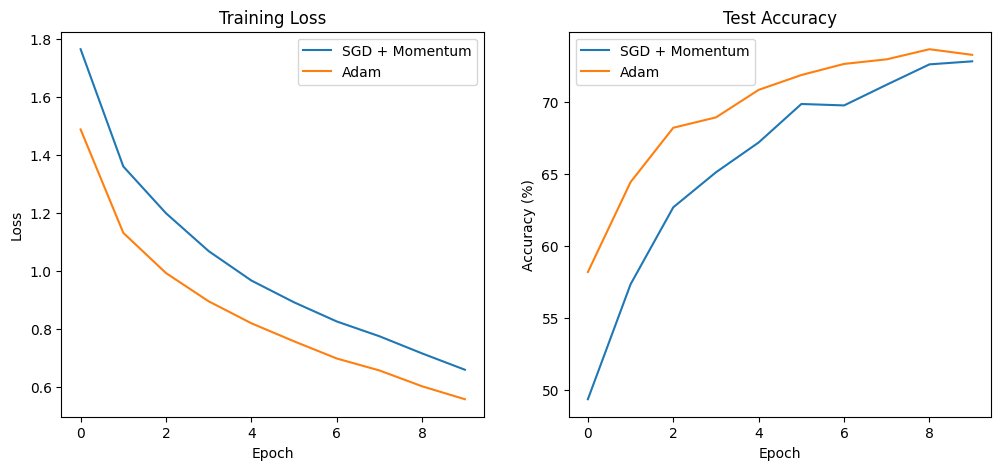

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(sgd_losses, label='SGD + Momentum')
plt.plot(adam_losses, label='Adam')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(sgd_acc, label='SGD + Momentum')
plt.plot(adam_acc, label='Adam')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()
